In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 


from sklearn import metrics, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, f1_score, plot_confusion_matrix

In [2]:
df_teste = pd.read_csv("desafio_manutencao_preditiva_teste.csv", sep = ",")
df_treino = pd.read_csv("desafio_manutencao_preditiva_treino.csv", sep = ",")

#Análise básica dos dados

Antes de começar, é preciso entender como está o dataframe, para isso será usada algumas funções que mostram de que forma está o dataframe.

In [3]:
df_treino.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


In [4]:
df_teste.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,446,L47625,L,297.5,308.6,1793,26.7,70
1,7076,L54255,L,300.7,310.5,1536,47.4,192
2,1191,L48370,L,297.2,308.4,1460,42.1,41
3,2618,L49797,L,299.4,309.1,1670,35.9,68
4,5067,L52246,L,304.1,313.1,1550,30.9,9


In [5]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB


In [6]:
df_treino.describe()

,udi,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,4994.589921,299.992515,309.992620,1537.419529,40.058512,108.098095
std,2896.125718,1.994710,1.488101,177.182908,9.950804,63.359915
min,1.000000,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,2496.500000,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,4983.000000,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,7510.500000,301.500000,311.100000,1612.000000,46.800000,162.000000
max,10000.000000,304.500000,313.800000,2886.000000,76.600000,251.000000


In [7]:
#Verificando se há dados ausentes
df_treino.isna().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

In [8]:
df_teste.isna().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
dtype: int64

In [9]:
#Quantos dados únicos há em cada coluna
df_treino.nunique()

udi                      6667
product_id               6667
type                        3
air_temperature_k          93
process_temperature_k      82
rotational_speed_rpm      840
torque_nm                 547
tool_wear_min             243
failure_type                6
dtype: int64

Com isso podemos explorar as variáveis como:
- Pelo tipo de máquina
- E a correlação entre as variáveis

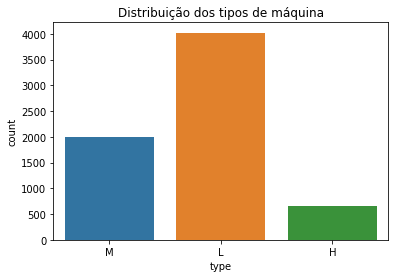

In [10]:
sns.countplot(x='type', data=df_treino);
plt.title('Distribuição dos tipos de máquina');
plt.show()

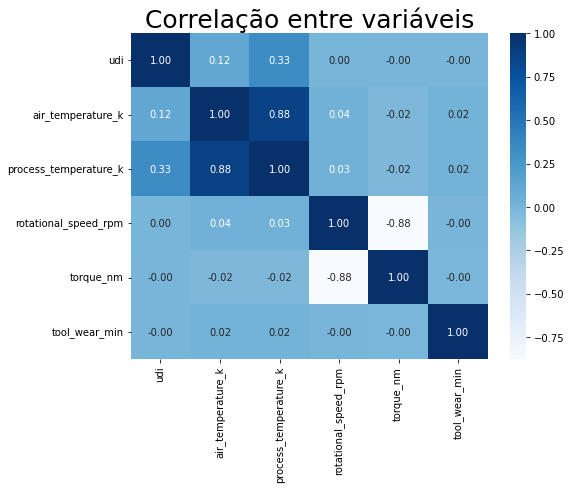

In [12]:
plt.figure(figsize=(8,6))
plt.title("Correlação entre variáveis", fontsize=25)

sns.heatmap(df_treino.corr(), annot= True, fmt=".2f", cbar = True, cmap = "Blues")

Através do gráfico de correlação podemos perceber que a temperatura do processo (process_temperature_k) e temperatura do ar (air_temperature) estão positivamente correlacionadas, ou seja, o aumento de uma implica no aumento de outra.
Enquanto a velociade de rotação e o torque estão negativamente correlacionados, com correlação negativa próxima de -1, significando que o aumento de um implica na diminuição de outro.

Mas para a modelagem não iremos utilizar todas as variáveis, sendo assim, será construído um novo dataframe para o modelo com as variáveis [air_temperature_k, process_temperature_k, rotational_speed_rpm, torque_nm e tool_wear_min e failure_type] já que as outras variáveis "udi", "product_id" e "type" representam identificação das máquinas e não serão necessárias para a montagem do modelo de previsão de falhas.

In [13]:
df_modelo = df_treino[['air_temperature_k','process_temperature_k','rotational_speed_rpm','torque_nm','tool_wear_min', 'failure_type']]

In [14]:
df_modelo.head(10)

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,298.1,308.6,1551,42.8,0,No Failure
1,298.2,308.7,1408,46.3,3,No Failure
2,298.2,308.7,1408,40.0,9,No Failure
3,298.1,308.6,1425,41.9,11,No Failure
4,298.1,308.6,1558,42.4,14,No Failure
5,298.1,308.6,1527,40.2,16,No Failure
6,298.3,308.7,1667,28.6,18,No Failure
7,298.4,308.9,1782,23.9,24,No Failure
8,298.6,309.1,1423,44.3,29,No Failure
9,298.6,309.2,1542,48.4,42,No Failure


Assim, podemos ver como essas colunas se comportam visualmente

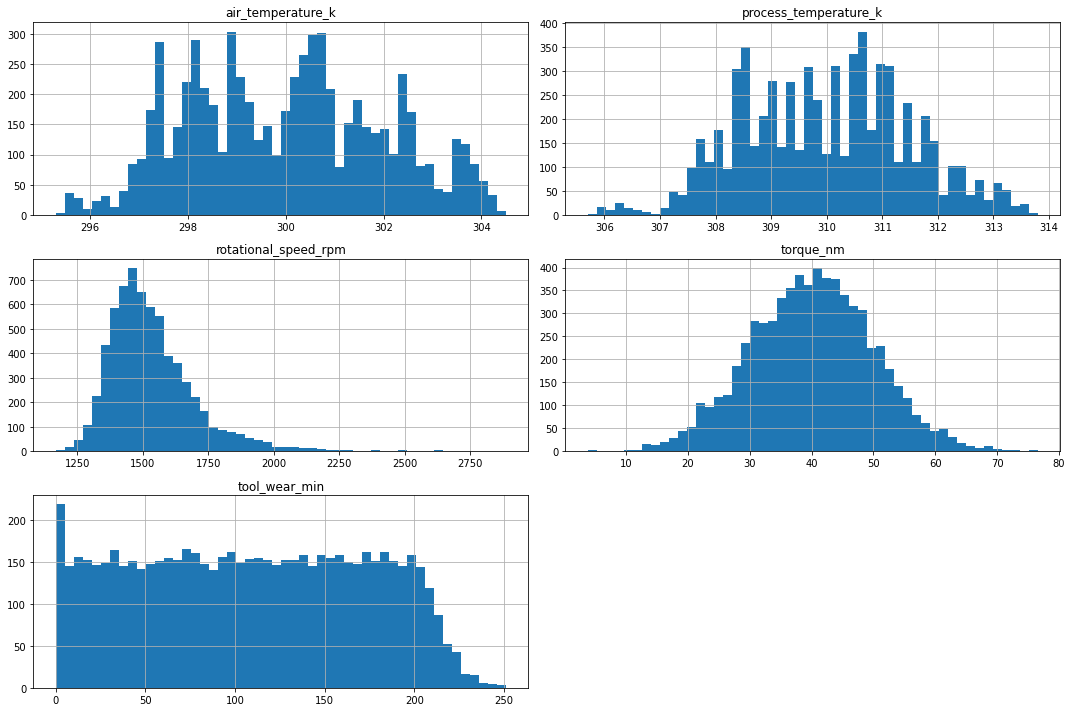

In [15]:
#Histograma de todas as features que iremos usar.
df_modelo.hist(bins=50, figsize=(15,10))
plt.tight_layout()
plt.show()

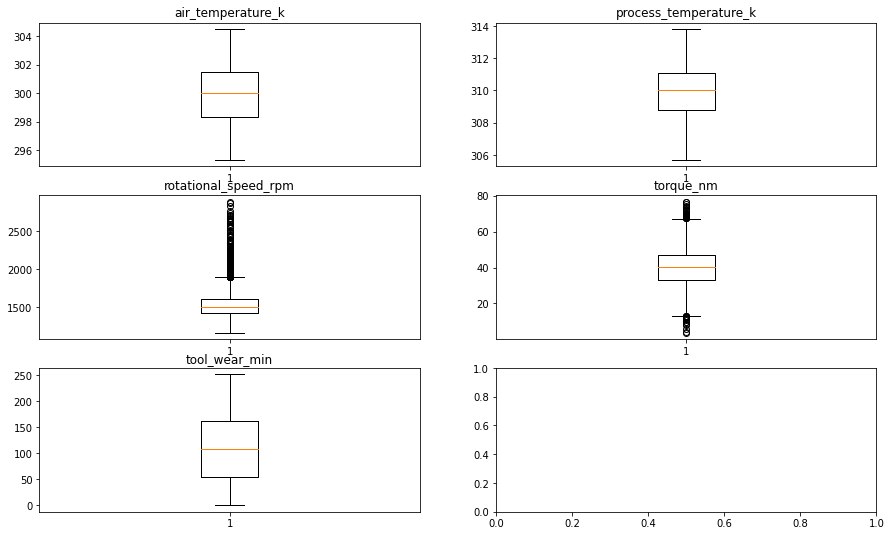

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 9), sharey=False)
axs[0, 0].boxplot(df_modelo['air_temperature_k'])
axs[0, 0].set_title('air_temperature_k')

axs[0, 1].boxplot(df_modelo['process_temperature_k'])
axs[0, 1].set_title('process_temperature_k')

axs[1, 0].boxplot(df_modelo['rotational_speed_rpm'])
axs[1, 0].set_title('rotational_speed_rpm')

axs[1, 1].boxplot(df_modelo['torque_nm'])
axs[1, 1].set_title('torque_nm')

axs[2, 0].boxplot(df_modelo['tool_wear_min'])
axs[2, 0].set_title('tool_wear_min')
plt.show()

#Modelo

Agora será criado o modelo de previsão do tipo de falhas de máquina utilizando regressão logística. Pois nesse caso esse tipo de modelo de regressão podemos prever a variável dependente considerando duas ou mais variáveis independentes.

##Regressão Logística

In [17]:
X = df_modelo[['air_temperature_k','process_temperature_k','rotational_speed_rpm','torque_nm','tool_wear_min']]
y = df_modelo['failure_type']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Agora vamos normalizar os dados para que seja possível trabalhar com valores com muita variabilidade.

In [19]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [20]:
model = LogisticRegression() #Modelo Regressão Logística
model.fit(X_scaled, y_train) #Teste do modelo de regressão

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

###Teste do modelo

In [21]:
y_pred = pd.Series(model.predict(scaler.transform(X_test)))

y_test = y_test.reset_index(drop=True)
y_comparison = pd.concat([y_test, y_pred], axis=1)
y_comparison.columns = ["Real", "Prediction"]
y_comparison.head()

,Real,Prediction
0,No Failure,No Failure
1,No Failure,No Failure
2,No Failure,No Failure
3,No Failure,No Failure
4,No Failure,No Failure


Através da tabela acima podemos perceber que o modelo conseguiu prever corretamente as 5, com isso podemos seguir para as métricas do modelo.

In [22]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", metrics.f1_score(y_test, y_pred, average='weighted'))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9730134932533733
Precision: 0.9635127724891355
Recall: 0.9730134932533733
F1-Score: 0.9655904814400553


###Matriz de confusão

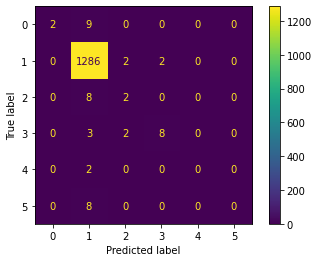

In [23]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) #Cálculo da matriz de confusão

metrics.ConfusionMatrixDisplay(cnf_matrix).plot()

##Previsão

Agora é preciso montar uma tabela com a previsão feita a partir dos dados.

In [24]:
x_predict = df_teste[['air_temperature_k','process_temperature_k','rotational_speed_rpm','torque_nm','tool_wear_min']]
y_pred1  = model.predict(x_predict)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [25]:
predicted_failure_type = pd.DataFrame()
predicted_failure_type['rowNumber'] = np.arange(len(y_pred1))
predicted_failure_type['predictedValues'] = pd.DataFrame(y_pred1)
predicted_failure_type.head()

,rowNumber,predictedValues
0,0,Power Failure
1,1,Power Failure
2,2,Power Failure
3,3,Power Failure
4,4,Power Failure


In [26]:
predicted_failure_type.to_csv('predicted.csv') #Exportar a nova tabela em csv